# Hi'iaka occultation

[Hiʻiaka](https://en.wikipedia.org/wiki/Hi%CA%BBiaka_(moon)) is the largest, outer moon of the trans-Neptunian dwarf planet Haumea. We observed Hiʻiaka occulting a bright star, helping in the study of the moon's orbital and physical parameters. 

This observation was done with the 1-m telescope [Artemis](https://www.speculoos.uliege.be/cms/c_4549211/en/speculoos-north-sno) and consists of 1 s. short exposures, requiring images to be small in size (46x41 pixels to reduce the overhead time of the telescope). In this tutorial, we will extract the raw flux time-series of the star occulted by Hi'iaka.

## Images

We start by scanning our dataset

In [2]:
from prose import FitsManager, utils

fm = FitsManager("/Users/lgrcia/data/Hiaka_occultation_20220609_Artemis", depth=1)
fm.observations(hide_exposure=False)

/Users/lgrcia/code/prose3/prose/console_utils.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Parsing FITS:   0%|          | 0/561 [00:00<?, ?it/s]

INFO telescope  not found - using default


,date,telescope,filter,type,target,width,height,exposure,files
id,,,,,,,,,
1,2022-06-09,,Clear,light,2002MS4_Artemis_clear_2x2bin,46,41,1.0,556
2,2022-06-09,,,bias,2002MS4_Artemis_clear_2x2bin,46,41,0.0,5


For this observation we only have bias calibration images.  We see that some images could not be recognized. To solve this problem we can define an Image loader with the telescope pre-defined

## Reference

We then detect the stars for which the photomety will be extracted

In [3]:
from prose import Sequence, blocks, FITSImage

images = fm.all_images
ref = FITSImage(images[0])

calibration = Sequence([
    blocks.Calibration(bias=fm.all_bias, loader=FITSImage),
    blocks.PointSourceDetection(n=1)
])

calibration.run(ref, show_progress=False, loader=FITSImage)

Let's vizualize the calibrated reference and define the radii of the apertures used to perform the photometry

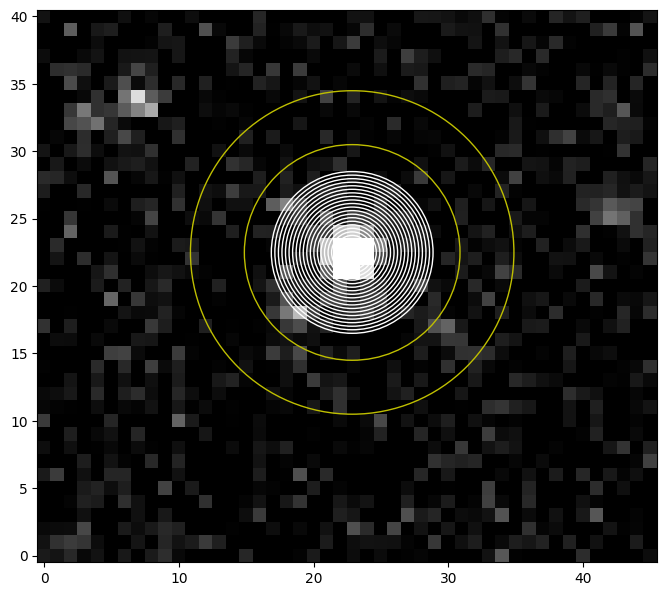

In [4]:
import numpy as np

ref.show(zscale=False)

radii = np.linspace(1, 6, 20)
for r in radii:
    ref.sources[0].plot(r, label=False, c="w")
    
rin, rout = 8, 12
ref.sources[0].plot(rin, label=False, c="y")
ref.sources[0].plot(rout, label=False, c="y")

## The reduction sequence

In [5]:
def copy_sources(image):
    image.sources = ref.sources.copy()

reduction = Sequence([
    *calibration,
    blocks.Apply(copy_sources),                                  # copy sources from ref
    blocks.CentroidQuadratic(limit=4),                           # centroiding
    blocks.AperturePhotometry(scale=False, radii=radii),         # aperture photometry
    blocks.AnnulusBackground(scale=False, rin=rin, rout=rout),   # local background estimate
    blocks.Get(                                                  # gettting data
        "jd", 
        path = lambda im: im.metadata["path"],
        fluxes = lambda im: im.aperture["fluxes"],
        bkg = lambda im: im.annulus["median"] * np.pi*(im.aperture['radii']**2),
        arrays=True
    )
])

reduction.run(images, loader=FITSImage)

  0%|          | 0/556 [00:00<?, ?images/s]

We can now retrieve our data from the [Get](prose.blocks.Get) block and instantiate a [Fluxes](prose.Fluxes) object

In [6]:
from prose.fluxes import Fluxes
import matplotlib.pyplot as plt

time = reduction.get.jd - 2450000
raw_fluxes = (reduction.get.fluxes - reduction.get.bkg[:, None, :]).T

fluxes = Fluxes(time=time, fluxes=raw_fluxes)

make the differential light curve, and plot it

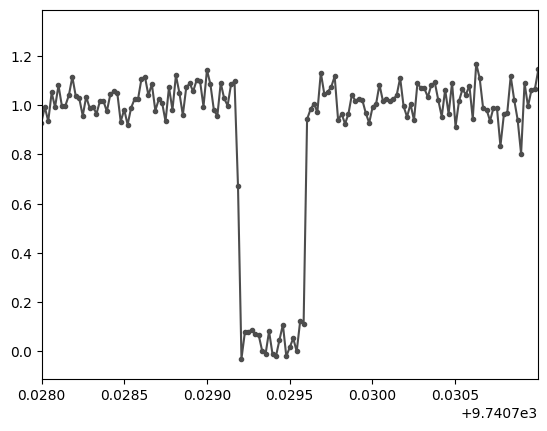

In [7]:
diff_fluxes = fluxes.diff()
diff_fluxes.estimate_best_aperture(target=0)
diff_fluxes.plot(color="0.3", ls="-")
_ = plt.xlim(9740.728, 9740.731)

This is a full occultation that we should be able to see on the images directly!

## Seeing the star disapear

In order to see the images as they are processed, we will use the `PlotVideo` block. It takes a plotting function as argument, which takes as input an `Image` object. Let's implement it

In [8]:
def plot(image):
    plt.figure(None, (10,4))
    ax = plt.subplot(121, xlabel="JD-utc - 2450000", ylabel="diff. flux")
    t0 = image.jd - 2450000
    mask = diff_fluxes.time < t0
    ax.plot(diff_fluxes.time[mask], diff_fluxes.flux[mask], ".-", c="0.3")
    plt.xlim(9740.7285, 9740.7305)
    ax.set_ylim(-0.2, 1.3)
    ax.set_title(f"Artemis 2002MS4 occultation ({ref.date.date()})")
    
    ax2 = plt.subplot(122)
    image.show(zscale=False, ax=ax2)
    image.sources.plot(radius=5, ax=ax2)
    plt.tight_layout()

and use it within a sequence that also contain the photometric extraction blocks

In [9]:
viz = Sequence([
    *reduction[0:-1],
    blocks.vizualisation.PlotVideo(plot, "hiaka.mp4", fps=17)
])

# Only the images close to the occultation
occ_images = reduction.get.path[(time > 9740.7285) & (time < 9740.7305)]
viz.run(occ_images, loader=FITSImage)

  0%|          | 0/95 [00:00<?, ?images/s]

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 400) to (1008, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7feaf214a000] Warning: data is not aligned! This can lead to a speed loss


Here is the movie where we indeed see the star being occulted

<video height="300px" loop autoplay muted style=" display: block; margin-left: auto; margin-right: auto;">
  <source src="../_static/hiaka.mp4" type="video/mp4">
</video>

![](static/hiaka.gif)

```{note}
Setting `limit=3` in [CentroidQuadratic](prose.blocks.CentroidQuadratic) allows to keep the aperture fixed when the star's centroid is farther than `limit` pixel away from the initial position (we see that on the video when the star is occulted)
```